In [1]:
# PROJET BIG DATA
# REALISE PAR :
# EL HARIRI OMAR ; ASSKLOU MERIEM; LOUARDI IKRAM
# ENCADRE PAR :
# Pr. Soussi Nassima

In [2]:
import sys
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import SparkSession


spark = SparkSession.builder.getOrCreate()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
spark

In [4]:
data=spark.read.csv("hdfs://hadoop-master:9000/Projet/Breast_Cancer.csv", header=True,inferSchema=True)

In [5]:
data.show()

+-------+--------------+--------------------+---------------------+----------------+------------------+----------+--------------+--------------+-------+---------+
|     ID|ClumpThickness|UniformityOfCellSize|UniformityOfCellShape|MarginalAdhesion|EpithelialCellSize|BareNuclei|BlandChromatin|NormalNucleoli|Mitoses|    Class|
+-------+--------------+--------------------+---------------------+----------------+------------------+----------+--------------+--------------+-------+---------+
|1000025|             5|                   1|                    1|               1|                 2|         1|             3|             1|      1|   benign|
|1002945|             5|                   4|                    4|               5|                 7|        10|             3|             2|      1|   benign|
|1015425|             3|                   1|                    1|               1|                 2|         2|             3|             1|      1|   benign|
|1016277|             

In [6]:
unique_classes = data.select('class').distinct()
unique_classes.show()

+---------+
|    class|
+---------+
|malignant|
|   benign|
+---------+



In [7]:
class_counts = data.groupBy('class').count()
class_counts.show()

+---------+-----+
|    class|count|
+---------+-----+
|malignant|  241|
|   benign|  458|
+---------+-----+



In [8]:
from pyspark.sql.functions import when
# Change the values of the "class" column based on the condition
data = data.withColumn("class", when(data["class"] == "benign", 0).otherwise(1))


In [9]:
data.show()

+-------+--------------+--------------------+---------------------+----------------+------------------+----------+--------------+--------------+-------+-----+
|     ID|ClumpThickness|UniformityOfCellSize|UniformityOfCellShape|MarginalAdhesion|EpithelialCellSize|BareNuclei|BlandChromatin|NormalNucleoli|Mitoses|class|
+-------+--------------+--------------------+---------------------+----------------+------------------+----------+--------------+--------------+-------+-----+
|1000025|             5|                   1|                    1|               1|                 2|         1|             3|             1|      1|    0|
|1002945|             5|                   4|                    4|               5|                 7|        10|             3|             2|      1|    0|
|1015425|             3|                   1|                    1|               1|                 2|         2|             3|             1|      1|    0|
|1016277|             6|                   8| 

In [10]:
class_counts = data.groupBy('class').count()
class_counts.show()

+-----+-----+
|class|count|
+-----+-----+
|    1|  241|
|    0|  458|
+-----+-----+



In [11]:
from pyspark.sql.functions import max, min

def max_min(column):
    for i in column:
        agg_df = data.agg(max(i), min(i))
        max_value = agg_df.first()[0]
        min_value = agg_df.first()[1]
        print(f"{i} : {min_value} - {max_value}")

max_min(data.columns)

ID : 61634 - 13454352
ClumpThickness : 1 - 10
UniformityOfCellSize : 1 - 10
UniformityOfCellShape : 1 - 10
MarginalAdhesion : 1 - 10
EpithelialCellSize : 1 - 10
BareNuclei : 1 - NA
BlandChromatin : 1 - 10
NormalNucleoli : 1 - 10
Mitoses : 1 - 10
class : 0 - 1


In [12]:
data.dtypes

[('ID', 'int'),
 ('ClumpThickness', 'int'),
 ('UniformityOfCellSize', 'int'),
 ('UniformityOfCellShape', 'int'),
 ('MarginalAdhesion', 'int'),
 ('EpithelialCellSize', 'int'),
 ('BareNuclei', 'string'),
 ('BlandChromatin', 'int'),
 ('NormalNucleoli', 'int'),
 ('Mitoses', 'int'),
 ('class', 'int')]

In [13]:
from pyspark.sql import functions as F
nan_count = data.where(F.isnan("BareNuclei")).count()
print(nan_count)
null_count = data.where(F.isnull("BareNuclei")).count()
print(null_count)

0
0


In [14]:
filtered_df = data.where(data["BareNuclei"] == "NA")
#filtered_df.show()
nl_count=data.where(data["BareNuclei"] == "NA").count()
print(nl_count)

16


In [15]:
import numpy as np
data = data.withColumn("BareNuclei", F.when(data["BareNuclei"] == "NA", np.nan).otherwise(data["BareNuclei"]))
#filtered_df.show()


In [16]:
nl_count=data.where(data["BareNuclei"] == np.nan).count()
print(nl_count)

16


In [17]:
from pyspark.sql import functions as F

# Cast the "BareNuclei" column to DoubleType
df_numeric = data.withColumn("BareNuclei", data["BareNuclei"].cast("double"))

# Compute the median of the "BareNuclei" column
median = df_numeric.approxQuantile("BareNuclei", [0.5], 0.25)[0]

# If there is an odd number of data points, the median is the middle value
if df_numeric.count() % 2 == 1:
  median = df_numeric.orderBy("BareNuclei").limit(1).select("BareNuclei").first()[0]
# If there is an even number of data points, the median is the mean of the two middle values
else:
  lower_median = df_numeric.orderBy("BareNuclei").limit(1).select("BareNuclei").first()[0]
  upper_median = df_numeric.orderBy("BareNuclei", ascending=False).limit(1).select("BareNuclei").first()[0]
  median = (lower_median + upper_median) / 2

# Print the median
print(median)

1.0


In [18]:
data = data.withColumn("BareNuclei", F.when(data["BareNuclei"] == np.nan,median ).otherwise(data["BareNuclei"]))

In [19]:
nl_count=data.where(data["BareNuclei"] == np.nan).count()
print(nl_count)

0


In [20]:
from pyspark.sql.functions import max, min

def max_min(column):
    for i in column:
        agg_df = data.agg(max(i), min(i))
        max_value = agg_df.first()[0]
        min_value = agg_df.first()[1]
        print(f"{i} : {min_value} - {max_value}")

max_min(data.columns)

ID : 61634 - 13454352
ClumpThickness : 1 - 10
UniformityOfCellSize : 1 - 10
UniformityOfCellShape : 1 - 10
MarginalAdhesion : 1 - 10
EpithelialCellSize : 1 - 10
BareNuclei : 1 - 9
BlandChromatin : 1 - 10
NormalNucleoli : 1 - 10
Mitoses : 1 - 10
class : 0 - 1


In [21]:
data.dtypes

[('ID', 'int'),
 ('ClumpThickness', 'int'),
 ('UniformityOfCellSize', 'int'),
 ('UniformityOfCellShape', 'int'),
 ('MarginalAdhesion', 'int'),
 ('EpithelialCellSize', 'int'),
 ('BareNuclei', 'string'),
 ('BlandChromatin', 'int'),
 ('NormalNucleoli', 'int'),
 ('Mitoses', 'int'),
 ('class', 'int')]

In [22]:
from pyspark.sql.functions import col

data = data.withColumn("BareNuclei", col("BareNuclei").cast("int"))
data.dtypes

[('ID', 'int'),
 ('ClumpThickness', 'int'),
 ('UniformityOfCellSize', 'int'),
 ('UniformityOfCellShape', 'int'),
 ('MarginalAdhesion', 'int'),
 ('EpithelialCellSize', 'int'),
 ('BareNuclei', 'int'),
 ('BlandChromatin', 'int'),
 ('NormalNucleoli', 'int'),
 ('Mitoses', 'int'),
 ('class', 'int')]

In [23]:
data.columns
from pyspark.sql.functions import isnull, sum

# Calculate the number of null values in each column
null_counts = data.select([sum(isnull(c).cast("int")).alias(c) for c in data.columns])

# Show the results
null_counts.show()

+---+--------------+--------------------+---------------------+----------------+------------------+----------+--------------+--------------+-------+-----+
| ID|ClumpThickness|UniformityOfCellSize|UniformityOfCellShape|MarginalAdhesion|EpithelialCellSize|BareNuclei|BlandChromatin|NormalNucleoli|Mitoses|class|
+---+--------------+--------------------+---------------------+----------------+------------------+----------+--------------+--------------+-------+-----+
|  0|             0|                   0|                    0|               0|                 0|         0|             0|             0|      0|    0|
+---+--------------+--------------------+---------------------+----------------+------------------+----------+--------------+--------------+-------+-----+



In [24]:
data.limit(5).show()

+-------+--------------+--------------------+---------------------+----------------+------------------+----------+--------------+--------------+-------+-----+
|     ID|ClumpThickness|UniformityOfCellSize|UniformityOfCellShape|MarginalAdhesion|EpithelialCellSize|BareNuclei|BlandChromatin|NormalNucleoli|Mitoses|class|
+-------+--------------+--------------------+---------------------+----------------+------------------+----------+--------------+--------------+-------+-----+
|1000025|             5|                   1|                    1|               1|                 2|         1|             3|             1|      1|    0|
|1002945|             5|                   4|                    4|               5|                 7|        10|             3|             2|      1|    0|
|1015425|             3|                   1|                    1|               1|                 2|         2|             3|             1|      1|    0|
|1016277|             6|                   8| 

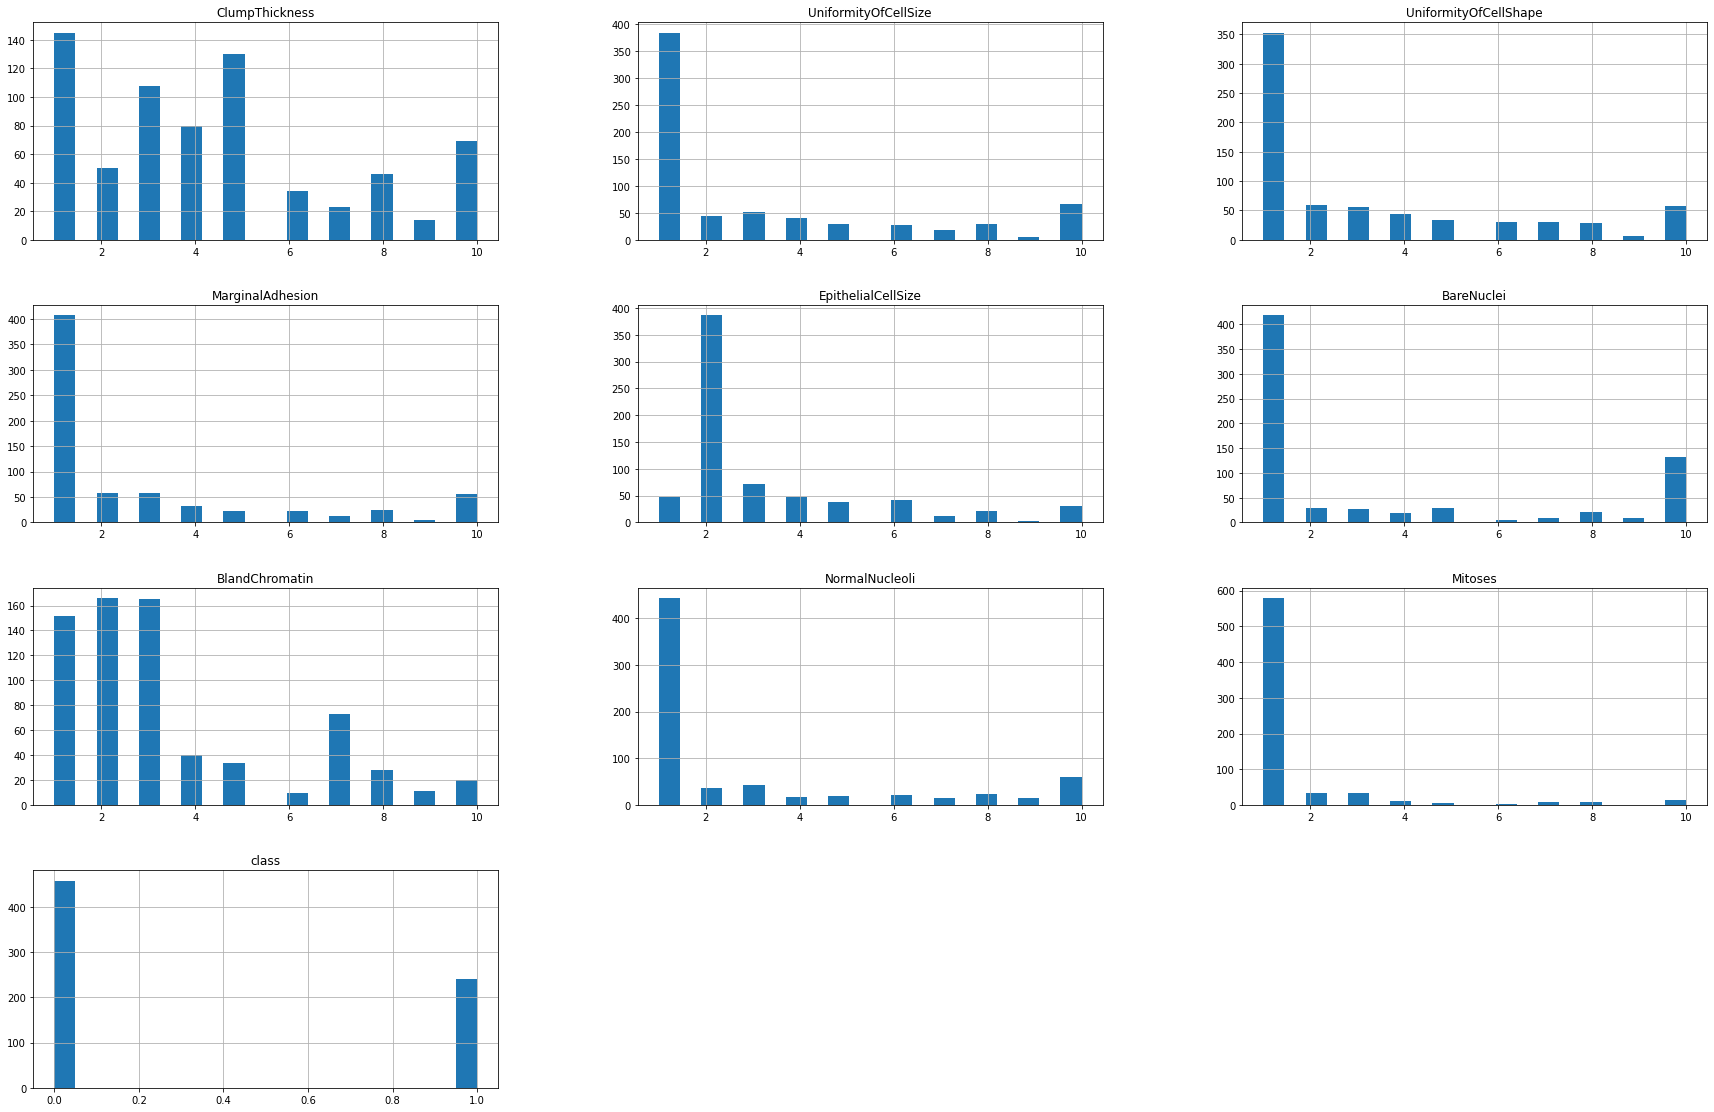

In [25]:
import matplotlib.pyplot as plt

df = data.select(['ClumpThickness', 'UniformityOfCellSize', 'UniformityOfCellShape','MarginalAdhesion','EpithelialCellSize',
                 'BareNuclei','BlandChromatin','NormalNucleoli','Mitoses','class'])
# Convert PySpark DataFrame to Pandas DataFrame
pdf = df.toPandas()

# Plot histograms
pdf.hist(bins=20, figsize=(30,30), layout=(6,3))

# Show plot
plt.show()

In [26]:
pdf.corr()

,ClumpThickness,UniformityOfCellSize,UniformityOfCellShape,MarginalAdhesion,EpithelialCellSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,class
ClumpThickness,1.000000,0.644913,0.654589,0.486356,0.521816,0.590008,0.558428,0.535835,0.350034,0.716001
UniformityOfCellSize,0.644913,1.000000,0.906882,0.705582,0.751799,0.686673,0.755721,0.722865,0.458693,0.817904
UniformityOfCellShape,0.654589,0.906882,1.000000,0.683079,0.719668,0.707474,0.735948,0.719446,0.438911,0.818934
MarginalAdhesion,0.486356,0.705582,0.683079,1.000000,0.599599,0.666971,0.666715,0.603352,0.417633,0.696800
EpithelialCellSize,0.521816,0.751799,0.719668,0.599599,1.000000,0.583701,0.616102,0.628881,0.479101,0.682785
BareNuclei,0.590008,0.686673,0.707474,0.666971,0.583701,1.000000,0.674215,0.574778,0.342397,0.818968
BlandChromatin,0.558428,0.755721,0.735948,0.666715,0.616102,0.674215,1.000000,0.665878,0.344169,0.756616
NormalNucleoli,0.535835,0.722865,0.719446,0.603352,0.628881,0.574778,0.665878,1.000000,0.428336,0.712244
Mitoses,0.350034,0.458693,0.438911,0.417633,0.479101,0.342397,0.344169,0.428336,1.000000,0.423170
class,0.716001,0.817904,0.818934,0.696800,0.682785,0.818968,0.756616,0.712244,0.423170,1.000000


Text(0.5, 1.0, 'CORELATIONS')

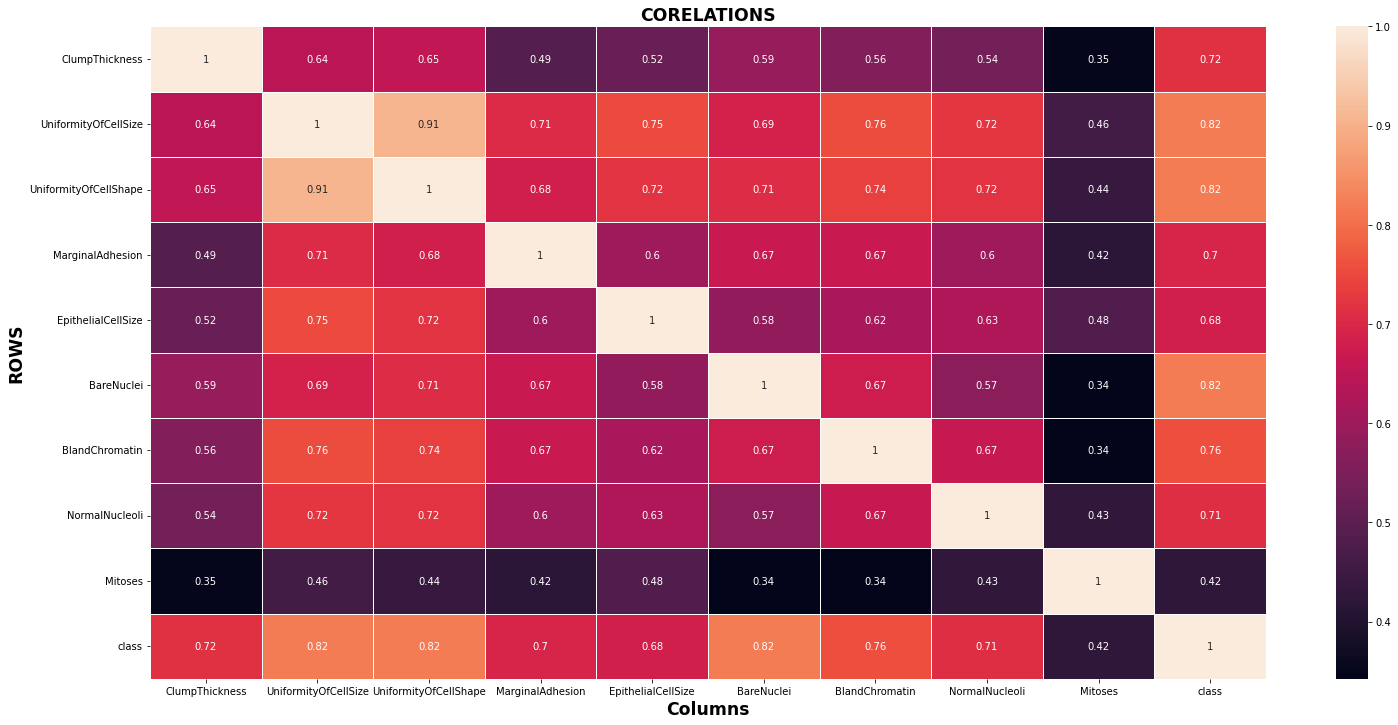

In [27]:
font = {
    'size': 'xx-large',
    'weight': 'bold'
}
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,12))
sns.heatmap(pdf.corr(),annot = True, linewidths=1,
           linecolor='w')
plt.xlabel('Columns',fontdict=font)
plt.ylabel('ROWS',fontdict=font)
plt.title('CORELATIONS', fontdict=font)

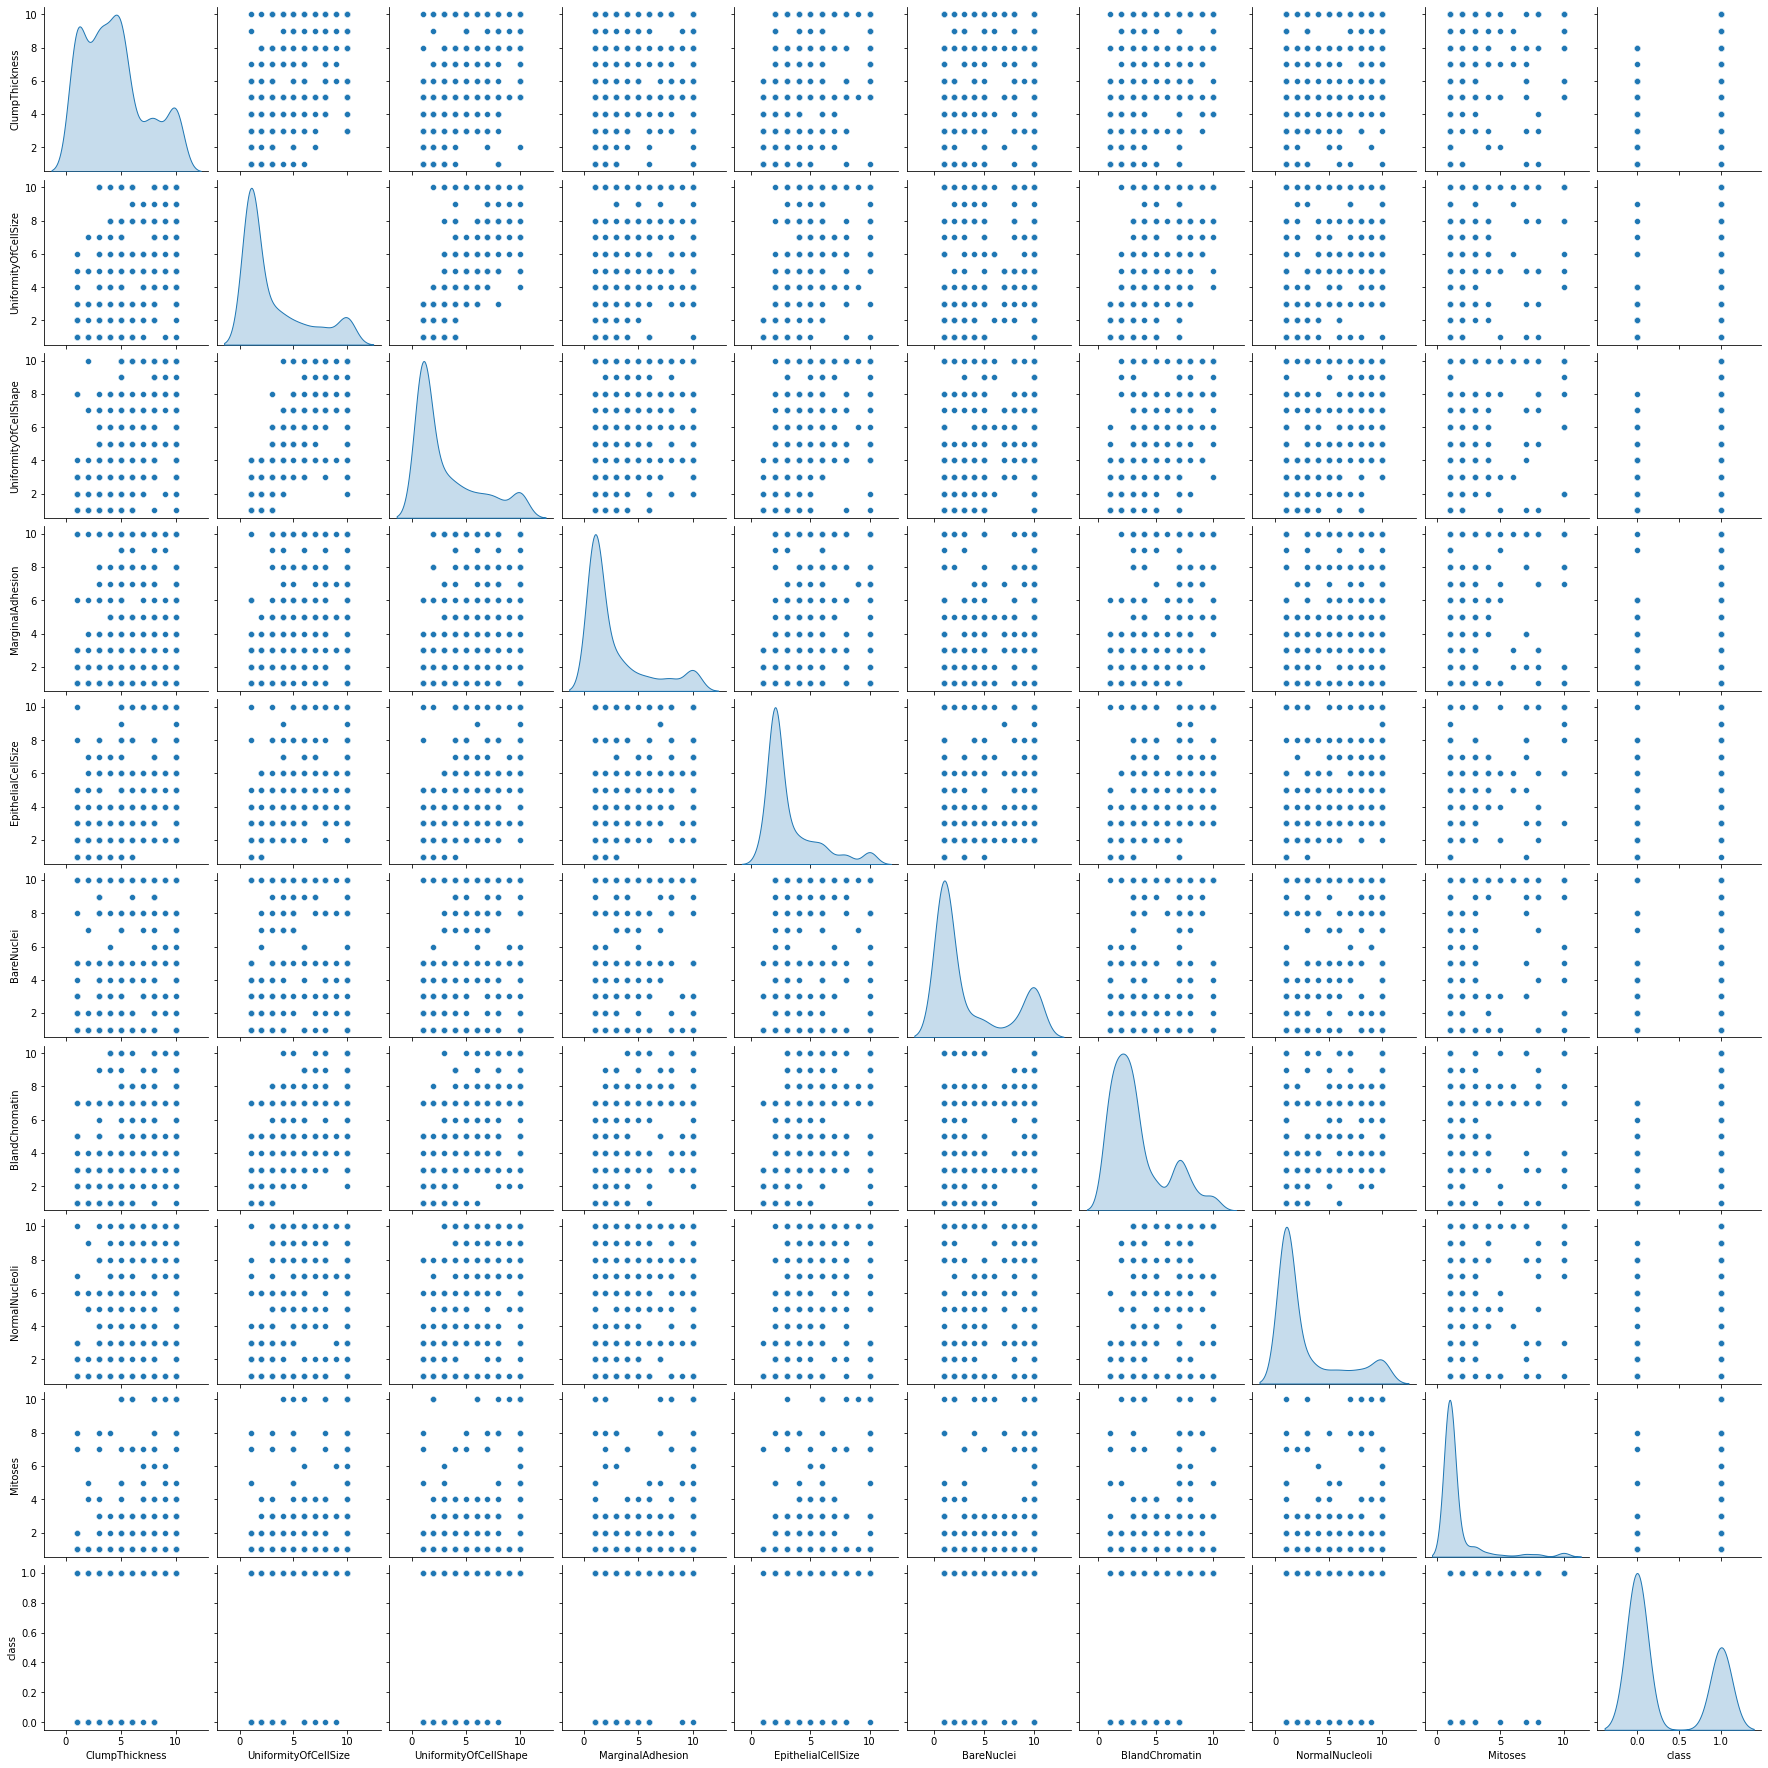

In [28]:
#Pairplot of the correlation/distribution between various independent attributes
sns.pairplot(pdf, diag_kind="kde")

In [29]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
features = ['ClumpThickness', 'UniformityOfCellSize', 'UniformityOfCellShape',
            'MarginalAdhesion','EpithelialCellSize', 'BareNuclei','BlandChromatin',
            'NormalNucleoli','Mitoses']
target = 'class'
# Split the data into training and test sets
df=data.select(features + [target])

train, test = df.randomSplit([0.7, 0.3])


assembler = VectorAssembler(inputCols=features, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

In [30]:
train.show()

+--------------+--------------------+---------------------+----------------+------------------+----------+--------------+--------------+-------+-----+--------------------+
|ClumpThickness|UniformityOfCellSize|UniformityOfCellShape|MarginalAdhesion|EpithelialCellSize|BareNuclei|BlandChromatin|NormalNucleoli|Mitoses|class|            features|
+--------------+--------------------+---------------------+----------------+------------------+----------+--------------+--------------+-------+-----+--------------------+
|             1|                   1|                    1|               1|                 1|         1|             1|             1|      1|    0|[1.0,1.0,1.0,1.0,...|
|             1|                   1|                    1|               1|                 1|         1|             1|             1|      1|    0|[1.0,1.0,1.0,1.0,...|
|             1|                   1|                    1|               1|                 1|         1|             1|             1|    

In [31]:
# Initialize the random forest model
rf = LogisticRegression(maxIter=10000, regParam=0.03, elasticNetParam=0.8)
rf = rf.setLabelCol(target)

# Fit the model to the training data
model = rf.fit(train)


predictions = model.transform(test)

In [32]:
predictions.show()

+--------------+--------------------+---------------------+----------------+------------------+----------+--------------+--------------+-------+-----+--------------------+--------------------+--------------------+----------+
|ClumpThickness|UniformityOfCellSize|UniformityOfCellShape|MarginalAdhesion|EpithelialCellSize|BareNuclei|BlandChromatin|NormalNucleoli|Mitoses|class|            features|       rawPrediction|         probability|prediction|
+--------------+--------------------+---------------------+----------------+------------------+----------+--------------+--------------+-------+-----+--------------------+--------------------+--------------------+----------+
|             1|                   1|                    1|               1|                 1|         1|             1|             1|      1|    0|[1.0,1.0,1.0,1.0,...|[4.16712159108094...|[0.98473968397617...|       0.0|
|             1|                   1|                    1|               1|                 1|     

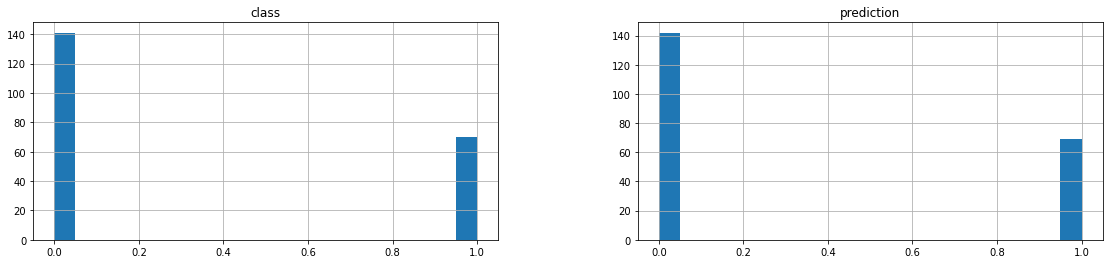

In [33]:
test=predictions.select(['class','prediction'])
# Convert PySpark DataFrame to Pandas DataFrame
pd = test.toPandas()

# Plot histograms
pd.hist(bins=20, figsize=(30,30), layout=(6,3))

# Show plot
plt.show()

In [34]:
# Calcul de l'erreur de prédiction
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='class')
accuracy = evaluator.evaluate(predictions)

# Affichage de l'erreur de prédiction
print("Erreur de prédiction : ", 1.0 - accuracy)


Erreur de prédiction :  0.005775075987841993


In [35]:

# Enregistrement du modèle dans HDFS
model.write().overwrite().save("hdfs://hadoop-master:9000/Projet/lrModel.h5")

In [36]:
# Import du type de modèle de régression logistique
from pyspark.ml.classification import LogisticRegressionModel
# Chargement du modèle à partir de HDFS
Model = LogisticRegressionModel.load("hdfs://hadoop-master:9000/Projet/lrModel.h5")

In [37]:
from pyspark.sql import SparkSession
#FONCTION DE LA CLASSIFICATION
def result(value):
    features = ['ClumpThickness', 'UniformityOfCellSize', 'UniformityOfCellShape',
            'MarginalAdhesion','EpithelialCellSize', 'BareNuclei','BlandChromatin',
            'NormalNucleoli','Mitoses']
    a=[value]
    val = spark.createDataFrame(a, features)
    val = assembler.transform(val)
    res=model.transform(val)
    value = res.select("prediction").first()[0]
    if value == 1.0:
        print("votre celul est : malignant ")
    else : 
        print("votre celul est : benign ")


In [38]:
#TEST DE LA FONCTION DE CLASSIFICATION
c=(9,9,9,9,9,9,9,9,9)
result(c)


votre celul est : malignant 
